<a href="https://colab.research.google.com/github/ry0y4n/point-e/blob/main/point_e/examples/test_text2pointcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 53 (delta 5), reused 53 (delta 5), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
import os
path = '/content/point-e'
os.chdir(path)

!ls

model-card.md  point_e	README.md  setup.py


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-4_8f83y1/clip_dfed59b836f14360818f7e48df8ead5c
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-4_8f83y1/clip_dfed59b836f14360818f7e48df8ead5c
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=a4f3fcd90601407ab7f4e733decfa25b9c9c15650fca11d007b14968a00a8882
  Stored in directory: /tmp/pip-ephem-wheel-cache-5e864fzd/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=99d1e0ececdb4dfc206f75726d77f663d1e81fee7be7ff6d9a21a58ca9fd9275
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af

In [ ]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 216MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
# Set a prompt to condition on.
prompt = 'a spherical sponge'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

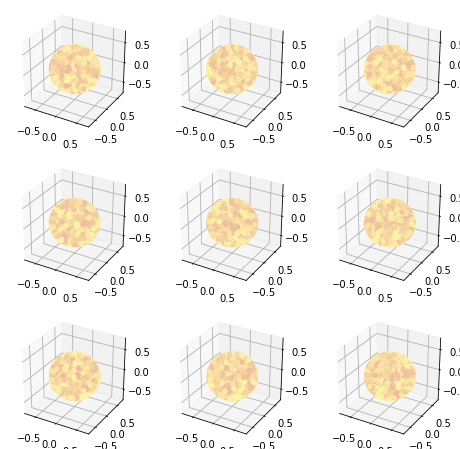

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))